In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from userinfluence import influence
from functools import reduce
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import pickle
from scipy import stats
def ARE_error(figname,label, ground_truth, estimation, m):
    a = [stats.percentileofscore(ground_truth, i) for i in ground_truth]
    b = [stats.percentileofscore(estimation, i) for i in estimation]
    ARE = list(np.abs(b - a)/a)
    plt.figure(figsize=(20,20))
    plt.ylabel("APE")
    plt.xlabel(label)
    plt.xticks(rotation=90)
    plt.boxplot(ARE,labels = m)
    plt.savefig(figname + ".pdf")
    plt.show()
    
def p_ij (cas,r = - 0.15):
    """Compute the probability of retweet bewtween any two user
    This function compute the Prob_ij for each user and Store
    it in matrix p_ij
    Args:
        cas: a list of Tweet object with in one cascade
        r: time decay coefficient,defaut set to -0.15
    Returns:
        p_ij: 2d numpy array    
   """
    nodes = cas
    n = len(nodes)
    #if n > 50 : print(“the size of cascade is”, n)
    k = 0
    t = np.zeros(n,dtype = np.float64)
    f = np.zeros(n,dtype = np.float64)
    p = np.zeros((n,n),dtype = np.float64)
    norm = np.zeros(n,dtype = np.float64)
    for node in nodes:
        if k == 0:
            p[0][0] = 1
            t[0] = node
            f[0] = 1
            k = k + 1
            continue
        t[k] = node
        f[k] = 1 # if node.num_follower == 0 else node.num_follower
        diff = node - t[0:k]
        p[:k, k] = ((r * (node - t[0:k])) + np.log(f[0:k])) # store the P_ji in log space
        for i in range(len(diff)):
            if diff[i] < 0:
                p[:k, k][i] = - np.inf
        norm[k] = reduce(np.logaddexp, p[:k, k])
        p[:k, k] = np.exp(p[:k, k] - norm[k])# recover the P_ji from log space
        k = k + 1
        
    return p

def gen_random_graph(n, fl = False):
    DG = nx.DiGraph()
    num_edges = np.random.randint(n, n**2)
    for _ in range(num_edges):
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)
        while( DG.has_edge(i,j) or i == j):
            i = np.random.randint(0, n)
            j = np.random.randint(0, n)
        DG.add_edge(i,j,weight = 1)
    if nx.is_weakly_connected(DG):
        return DG
    
    else:
        comps = nx.weakly_connected_components(DG)
        path = []
        for comp in comps:
            path.append( comp.pop() )
        DG.add_path(path)
        assert(nx.is_weakly_connected(DG))
        
        return DG
    
        

def sample_wait_time_graph(DG, shape):#(adj_mat):
    for e in DG.edges(data = True):
        rate = np.random.weibull(shape)
        s = np.random.uniform(0,1)
        tau = - np.log(s)/rate
        e[2]['weight'] = tau
    return DG
        
    
def gen_cascade(SG, source = 0):
    cascade = np.zeros((2,len(SG)))

    length = nx.single_source_dijkstra_path_length(SG,source)

    for node in length:
        cascade[1,node] = length[node]
        cascade[0,node] = node

    return cascade
def gen_count(SG, source = 0):
    path = nx.single_source_dijkstra_path(SG,source)
    count = np.zeros(len(SG))
    for node in path:
        for i in path[node]:
            count[i] = count[i] + 1
    return count

def experiment(td, shape, n = 100, tms = 100, flc = True):
    gt = np.zeros(n)
    est = np.zeros(n)
    rand_G = gen_random_graph(n)
    for _ in range(tms):
        SG = sample_wait_time_graph(rand_G,shape)
        gt = gt + gen_count(SG)
        cas = gen_cascade(SG)
        est = est + rearrage(cas, td)
        
    return gt/tms, est/tms
def rearrage(u_time,td):
#     print(u_time)
    u = np.zeros(len(u_time))
    index = np.argsort(u_time[1])
    u_time = u_time[:, index]
#     print(u_time)
    P = p_ij( u_time[1], r = td)
    inf = influence(P**2)
    inf = np.array([inf])
#     print(inf)
    u_time = np.concatenate( (u_time, inf), axis = 0)
    index = np.argsort(u_time[0])
    u_time = u_time[:, index]
#     print(u_time)
    
    return u_time[2]
        

In [6]:
td = -0.001
a,b = experiment(td, 2, tms = 100)
print(a)
print(b)

[ 100.      2.99    7.05    1.76    4.53    6.09    3.08    3.91    3.35
    3.43    6.13    6.43    2.37    3.49    1.      3.21    3.83    3.57
    4.01    5.11    4.13    4.14   23.8     2.34    6.81    2.74    3.7
   10.12    3.71    4.44    3.5     2.58    7.52    9.29    2.62    5.01
    2.49    3.67    1.3     3.09    4.62    4.45   28.32    1.8     2.6
    2.13    3.53    5.95    2.25    4.38    6.61    3.98    3.88    2.61
    8.39    5.62    2.57    2.94    2.8     5.5     1.82    1.41    3.9
   14.83    2.59    4.45    4.38    1.95    3.08    3.5     2.61    5.78
    3.78    1.64    1.33    3.57    8.65    7.33    5.86    5.49    6.3
   11.99    1.7     6.3     3.8     3.79    1.7     5.01    1.69    1.66
    3.87    4.23    2.79   16.49    1.36    2.9     2.24    2.3     2.72
    4.22]
[ 3.63901201  1.00863961  1.03695315  1.00398528  1.03049073  1.19349998
  1.0204598   1.03334842  1.04418898  1.05112162  1.03716028  1.04168409
  1.00554912  1.01546659  1.01109278  1.02146

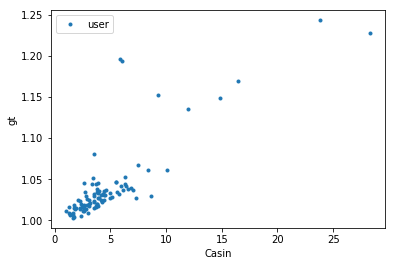

PersonrResult (0.96333608026964079, 8.4245866743741714e-58)
SpearmanrResult(correlation=0.82226042737402838, pvalue=9.9423099158833666e-26)
KendalltauResult(correlation=0.63471869365480582, pvalue=8.2173842865890969e-21)


In [8]:
be = 1
ed = 100
#plt.figure(figsize=(10,5))
plt.plot(a[be:ed],b[be:ed], ".")
plt.ylabel("gt")
plt.xlabel("Casin")
#plt.title("our method  r = %f" % td)
plt.legend(["user"])
plt.savefig("test2.pdf")
plt.show()
print("PersonrResult", pearsonr(a,b))
print (spearmanr(a,b))
print (kendalltau(a,b))


In [10]:
DG = nx.DiGraph()
DG.add_edge(1,2,weight = 1)
DG.add_edge(3,4,weight = 1)
# for e in DG.edges(data = True):
#     #DG.add_edge(e[0],e[1],weight = 0)
#     e[2]['weight'] = 8 
# for e in DG.edges(data = True):
#     print("1")
#     print(e)
print(nx.is_weakly_connected(DG))
a = nx.weakly_connected_components(DG)
for i in a:
    print(i)
    print(i.pop())
    

False
{1, 2}
1
{3, 4}
3


In [15]:
G = gen_random_graph(5)
# nx.draw(G,arrows = True, with_labels = True, node_color = 'lightgrey' )
# plt.show()
for e in G.edges(data = True):
    print(e)
SG = sample_wait_time_graph(G,2)
for e in SG.edges(data = True):
    print(e)

(4, 0, {'weight': 1})
(0, 3, {'weight': 1})
(1, 0, {'weight': 1})
(1, 3, {'weight': 1})
(1, 4, {'weight': 1})
(4, 0, {'weight': 0.0096048779410769416})
(0, 3, {'weight': 1.722359686096717})
(1, 0, {'weight': 2.1926564861013058})
(1, 3, {'weight': 0.12875924844946549})
(1, 4, {'weight': 0.50137314229793484})


/home/yifei/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/yifei/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/yifei/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/yifei/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

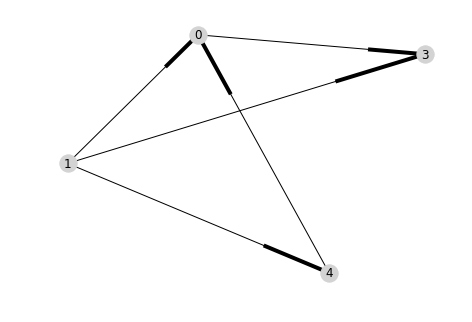

In [16]:
nx.draw(SG,arrows = True, with_labels = True, node_color = 'lightgrey' )
plt.show()

In [17]:
print(gen_count(SG))

[ 2.  0.  0.  1.]
